<a href="https://colab.research.google.com/github/krmonline/PII/blob/main/%E0%B8%8A%E0%B8%B7%E0%B9%88%E0%B8%AD%E0%B8%84%E0%B8%99.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
!pip install pythainlp  > /dev/null

In [59]:
from bs4 import BeautifulSoup
import requests
import pickle
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [7]:
!pip install faker

     |████████████████████████████████| 1.1MB 5.2MB/s 


ทำการแปลง Character เป็น Array ต้นฉบับมาจากอาจารย์เอกพล
https://github.com/ekapolc/nlp_course/blob/master/HW1/Word_Tokenizer_Lab.ipynb

และ มีการจัดการกับ Out Of Vocab โดยที่คำที่เราไม่รู้จักให้ไปลงที่  "\ufeff"



In [40]:
CHARS = [
  '\n', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+',
  ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8',
  '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E',
  'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R',
  'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_',
  'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
  'n', 'o', 'other', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y',
  'z', '}', '~', 'ก', 'ข', 'ฃ', 'ค', 'ฅ', 'ฆ', 'ง', 'จ', 'ฉ', 'ช',
  'ซ', 'ฌ', 'ญ', 'ฎ', 'ฏ', 'ฐ', 'ฑ', 'ฒ', 'ณ', 'ด', 'ต', 'ถ', 'ท',
  'ธ', 'น', 'บ', 'ป', 'ผ', 'ฝ', 'พ', 'ฟ', 'ภ', 'ม', 'ย', 'ร', 'ฤ',
  'ล', 'ว', 'ศ', 'ษ', 'ส', 'ห', 'ฬ', 'อ', 'ฮ', 'ฯ', 'ะ', 'ั', 'า',
  'ำ', 'ิ', 'ี', 'ึ', 'ื', 'ุ', 'ู', 'ฺ', 'เ', 'แ', 'โ', 'ใ', 'ไ',
  'ๅ', 'ๆ', '็', '่', '้', '๊', '๋', '์', 'ํ', '๐', '๑', '๒', '๓',
  '๔', '๕', '๖', '๗', '๘', '๙', '‘', '’', '\ufeff'
]
CHARS_MAP = {v: k for k, v in enumerate(CHARS)}

def name2arr(x):
  result = ""
  for i in x:
    if i not in CHARS_MAP:
      i = '\ufeff' #OutOfVocab
    if result == "":
      result = str(CHARS_MAP[i])
    else:
      result = result + "," + str(CHARS_MAP[i])
  return result

ทำการเตรียมชื่อ

In [41]:
df_name1 = pd.read_csv('https://raw.githubusercontent.com/krmonline/PII/main/name.csv')
df_name2 = pd.read_csv('https://raw.githubusercontent.com/krmonline/PII/main/mock_name_address.csv')

In [48]:
df_name2['name'] = df_name2.FName.apply(lambda x: x.split(" ")[0])

In [122]:
arr_name1 = df_name1.name.values
#arr_userdefined = np.array(['สมหมาย','สมชาย','สมเกียรติ','ประเทือง']) #เพิ่มชื่อด้วยตังเองเมื่อเห็นว่าชื่อไม่เคยเทรนมาก่อน
#arr_name1 = np.concatenate([arr_name1,arr_userdefined])

In [123]:
arr_name = np.concatenate([df_name1.name.values,df_name2.name.values])
arr_name = pd.DataFrame(arr_name,columns=['name']).name.unique()
df_name = pd.DataFrame(arr_name,columns=['name'])

In [126]:
df_name[df_name.name == 'สมเกียรติ'] #check ว่าชื่ออยู่ใน data  frame  หรือเปล่า

,name
562,สมเกียรติ


แปลงชื่อมาเป็น Array และกำหนด Label ให้เป็น 1
โดย 1 = เป็นชื่อคน และ 0 = ไม่ใช่ชื่อคน
เราจะได้ Array ซึ่งเป็นค่า key ของแต่ละ Character

In [127]:
df_name["arr_num"] = df_name.name.apply(name2arr)
df_name['label'] = 1
df_name

,name,arr_num,label
0,กมลภู,"94,126,130,125,149",1
1,กรกวรรษ,"94,128,94,131,128,128,133",1
2,กรณ์,"94,128,112,163",1
3,กฤศ,"94,129,132",1
4,กฤษิกร,"94,129,133,144,94,128",1
...,...,...,...
1005,จักรีรัตน์,"101,141,94,128,145,128,141,114,118,163",1
1006,นารดา,"118,142,128,113,142",1
1007,อาแอเสาะ,"137,142,152,137,151,134,142,140",1
1008,คมกฤชญ์,"97,126,94,129,103,106,163",1


In [128]:
#df_name.to_csv("./name.csv",index=False)

#เตรียมชื่อนามทั่วไป

In [129]:
import pythainlp.word_vector
import random

สุ่มคำจาก word_vector มาจำนวนเท่าๆกับชื่อคนเพื่อเป็น DataSet ของคำที่ไม่่ใช่ชื่อคน

In [130]:
model = pythainlp.word_vector.get_model()
arr_tmp = []
for i  in range(len(df_name)):
  nameID = random.randint(0,2000)
  name = model.index2word[nameID]
  arr_tmp.append(name)
print("Random general word =",len(arr_tmp))
df2 = pd.DataFrame(arr_tmp,columns=['name'])
df2["arr_num"] = df2.name.apply(name2arr) #Check OOV ใน function แล้ว
df2['label'] = 0

Random general word = 1010


#Merge Data

In [131]:
df = pd.concat([df_name,df2])
df.head()

,name,arr_num,label
0,กมลภู,"94,126,130,125,149",1
1,กรกวรรษ,"94,128,94,131,128,128,133",1
2,กรณ์,"94,128,112,163",1
3,กฤศ,"94,129,132",1
4,กฤษิกร,"94,129,133,144,94,128",1


หาค่าจำนวน  Character สูงสุดที่เป็นไปได้และเพิ่มไปอีก 1.5 เท่า
เป็นข้อจำกัดของ LSTM ที่ต้องกำหนดค่าสูงสุดของตัวอักษรในที่นี้คือ maxlen

In [132]:
arr_numID = []
maxlen = 0
n = 0
for i in df.arr_num:
  n = n+1
  #print(n,i)
  arr_tmp = [int(iInt) for iInt in i.split(',')]
  #print(arr_tmp)
  arr_numID.append(arr_tmp)
  #print(i.split(','))
  lentmp = len(arr_numID[-1])
  if maxlen < lentmp:
    maxlen = lentmp
maxlen = int(maxlen*1.5)
print(maxlen)
#ได้ maxlen

30


In [133]:
#arr_numID[:5],df.label.values[:5]

#แบ่ง Train Test

In [134]:
from sklearn.model_selection import train_test_split

ทำ padding ให้กับคำโดยเติม 0 ไปข้างหน้าให้เต็ม เช่น [0,0,0,192,191,176,123]

In [135]:
X = tf.keras.preprocessing.sequence.pad_sequences(
    arr_numID, maxlen=maxlen, dtype='int32', padding='pre',
    truncating='pre', value=0.0
)
y = df.label.values

แบ่ง Dataset  ออกมา 3 ส่วน ประกอบด้วย Train Set,Test Set,Validation Set

In [137]:
X_trainTMP, X_test, y_trainTMP, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_valid, y_train, y_valid = train_test_split(X_trainTMP, y_trainTMP, test_size=0.3, random_state=42)
X_train.shape,y_train.shape,X_valid.shape,y_valid.shape,X_test.shape,y_test.shape,

((1131, 30), (1131,), (485, 30), (485,), (404, 30), (404,))

#Train ด้วย LSTM

In [138]:
vocab_size = len(CHARS)
print(vocab_size)
del(model)
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 1, input_length=maxlen),
    tf.keras.layers.LSTM(1,return_sequences=False),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss=tf.keras.losses.binary_crossentropy,optimizer='adam',metrics=['accuracy'])
model.summary()
loss = []
val_loss = []
acc = []
val_acc = []

178
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 1)             178       
_________________________________________________________________
lstm_1 (LSTM)                (None, 1)                 12        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2         
Total params: 192
Trainable params: 192
Non-trainable params: 0
_________________________________________________________________


In [142]:
%%time
history_tmp = model.fit(X_train,y_train,epochs=100,validation_data=(X_valid,y_valid),verbose=1)

Epoch 1/100
36/36 [==============================] - 1s 16ms/step - loss: 0.3419 - accuracy: 0.8753 - val_loss: 0.4000 - val_accuracy: 0.8474
Epoch 2/100
36/36 [==============================] - 1s 14ms/step - loss: 0.3412 - accuracy: 0.8798 - val_loss: 0.4002 - val_accuracy: 0.8495
Epoch 3/100
36/36 [==============================] - 1s 15ms/step - loss: 0.3429 - accuracy: 0.8789 - val_loss: 0.3997 - val_accuracy: 0.8433
Epoch 4/100
36/36 [==============================] - 1s 14ms/step - loss: 0.3413 - accuracy: 0.8789 - val_loss: 0.3995 - val_accuracy: 0.8495
Epoch 5/100
36/36 [==============================] - 0s 14ms/step - loss: 0.3414 - accuracy: 0.8789 - val_loss: 0.3996 - val_accuracy: 0.8474
Epoch 6/100
36/36 [==============================] - 1s 15ms/step - loss: 0.3407 - accuracy: 0.8798 - val_loss: 0.3998 - val_accuracy: 0.8433
Epoch 7/100
36/36 [==============================] - 0s 14ms/step - loss: 0.3405 - accuracy: 0.8798 - val_loss: 0.3999 - val_accuracy: 0.8412
Epoch 

In [143]:
loss.extend(history_tmp.history['loss'])
val_loss.extend(history_tmp.history['val_loss'])
acc.extend(history_tmp.history['accuracy'])
val_acc.extend(history_tmp.history['val_accuracy'])

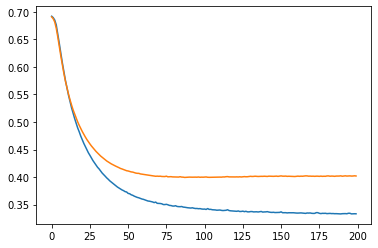

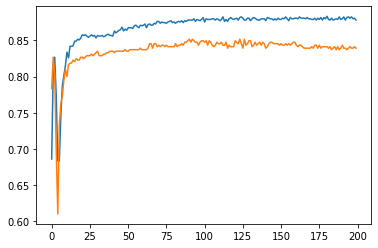

In [144]:
plt.plot(loss)
plt.plot(val_loss)
plt.show()
plt.plot(acc)
plt.plot(val_acc)

ทดสอบ โดยหาชื่อมาลอง Predict ดู

In [156]:
import  numpy as np
name = "รักษา"
arr = [int(i) for i in name2arr(name).split(",")]
dataTest = tf.keras.preprocessing.sequence.pad_sequences(np.array([arr]), maxlen=maxlen, dtype='int32', padding='pre',truncating='pre', value=0.0)
model.predict(dataTest)

array([[0.84173465]], dtype=float32)

#Evaluation

In [157]:
from sklearn import metrics

In [158]:
pred = model.predict_classes(X_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [159]:
print(metrics.classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.90      0.74      0.81       226
           1       0.73      0.89      0.81       178

    accuracy                           0.81       404
   macro avg       0.82      0.82      0.81       404
weighted avg       0.83      0.81      0.81       404



In [160]:
pred = model.predict(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test,pred)

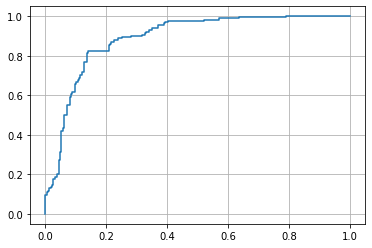

In [161]:
plt.grid()
plt.plot(fpr,tpr)